## Bayesian Optimisation in a Parallel Setting - Code

To start off, we need to install and/or import the relevant libraries:

In [1]:
#!pip install gpyopt
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from GPyOpt.methods import ModularBayesianOptimization
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd

The objective function we will be looking at is the 2-dimensional Branin function, visualised here:

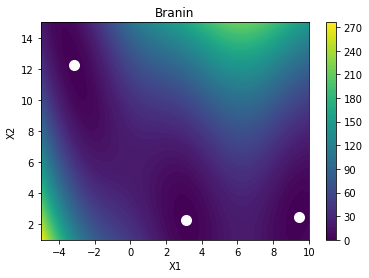

In [2]:
func  = GPyOpt.objective_examples.experiments2d.branin()
func.plot()

To implement the KB and CL methods, we need to construct a modified BO object with additional parameters "method_type" and "batch_numb".

In [3]:

class ModifiedModularBO(ModularBayesianOptimization):
    
    
    
    def __init__(self, model, space, objective, acquisition, evaluator,
                 X_init, Y_init=None, cost = None, normalize_Y = True,
                 model_update_interval = 1, de_duplication=False,
                 method_type='KB', batch_num=1):

        # --- Create optimization space
        super().__init__(model                  = model,
                         space                  = space,
                         objective              = objective,
                         acquisition            = acquisition,
                         evaluator              = evaluator,
                         X_init                 = X_init,
                         Y_init                 = Y_init,
                         cost                   = cost,
                         normalize_Y            = normalize_Y,
                         model_update_interval  = model_update_interval,
                         de_duplication         = de_duplication)
        self.method_type=method_type
        self.batch_num=batch_num

    def _compute_next_evaluations(self, pending_zipped_X=None, ignored_zipped_X=None):
        #Returns a list of batch_num points to next be evaluated.
        
        
        if self.X is not None and self.Y is None:
            self.Y, _ = self.objective.evaluate(self.X)

        self.model.updateModel(self.X, self.Y, 0, 0)
        
        #Compute first evaluation point
        evaluation_point, _ = self.acquisition.optimize()
        evaluation_points = deepcopy(evaluation_point)
        X_b = deepcopy(evaluation_point)
        if self.method_type == 'KB':
            Y_b = self.model.predict(evaluation_point)[0]
        elif self.method_type == 'CL_min':
            Y_b = np.array(min(self.Y), ndmin=2)
        elif self.method_type == 'CL_max':
            Y_b = np.array(max(self.Y), ndmin=2)
        
        self.model.updateModel(np.concatenate([self.X, X_b]),
                                   np.concatenate([self.Y, Y_b]),
                                   X_b, Y_b)
        
        for b in range(1, self.batch_num):
            
            
            #Compute next evaluation point by optimising acquisition function
            evaluation_point, _ = self.acquisition.optimize()
            evaluation_points = np.concatenate([evaluation_points,
                                                deepcopy(evaluation_point)])
            #Update belief set
            X_b= np.concatenate([X_b,evaluation_point])
            if self.method_type == 'KB':
                Y_b = np.concatenate([Y_b, self.model.predict(evaluation_point)[0]])
            elif self.method_type == 'CL_min':
                Y_b = np.concatenate([Y_b, np.array(min(self.Y), ndmin=2)])
            elif self.method_type == 'CL_max':
                Y_b = np.concatenate([Y_b, np.array(max(self.Y), ndmin=2)])
            
            #Update model
            self.model.updateModel(np.concatenate([self.X, X_b]),
                                   np.concatenate([self.Y, Y_b]),
                                   X_b, Y_b)
    
        return(evaluation_points)
        
 

Example recommended points for the 9-point grid:

In [4]:
func  = GPyOpt.objective_examples.experiments2d.branin()

objective = GPyOpt.core.task.SingleObjective(func.f)
space = GPyOpt.Design_space(space =[{'name': 'var_1',
                                     'type': 'continuous',
                                     'domain':(-5,10)},
                                    {'name': 'var_2',
                                     'type': 'continuous',
                                     'domain': (1,15)}])
model = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
initial_design = GPyOpt.experiment_design.initial_design('grid', space, 9)
acquisition = GPyOpt.acquisitions.select_acquisition('EI')(model, space, optimizer=acquisition_optimizer, jitter=0)
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
max_iter=1
batch_num=6
bo_kb = ModifiedModularBO(model, space, objective, acquisition, evaluator, initial_design, method_type='KB', batch_num=batch_num)                                      
bo_kb.run_optimization(max_iter=max_iter) 

bo_clmin = ModifiedModularBO(model, space, objective, acquisition, evaluator, initial_design, method_type='CL_min', batch_num=batch_num)
bo_clmin.run_optimization(max_iter=max_iter)

bo_clmax = ModifiedModularBO(model, space, objective, acquisition, evaluator, initial_design, method_type='CL_max', batch_num=batch_num)                                
bo_clmax.run_optimization(max_iter = max_iter) 

Note: in grid designs the total number of generated points is the smallest closest integer of n^d to the selected amount of points


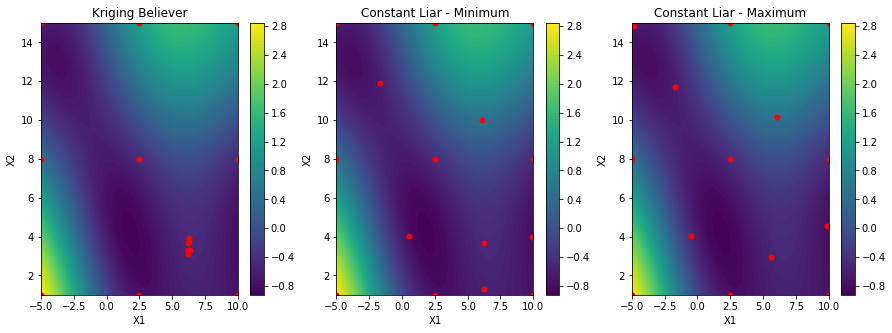

In [5]:
model_dict = {"Kriging Believer":bo_kb,
              "Constant Liar - Minimum":bo_clmin,
              "Constant Liar - Maximum":bo_clmax}

i=0
plt.figure(figsize=(15,5))
for name_, model_ in model_dict.items():
    
    model_to_plot = deepcopy(model_)


    bounds = model_to_plot.acquisition.space.get_bounds()
    model = model_to_plot.model
    Xdata = model_to_plot.X
    Ydata = model_to_plot.Y
    acquisition_function = model_to_plot.acquisition.acquisition_function
    label_x = 'X1'
    label_y = 'X2'

    X1 = np.linspace(bounds[0][0], bounds[0][1], 200)
    X2 = np.linspace(bounds[1][0], bounds[1][1], 200)
    x1, x2 = np.meshgrid(X1, X2)
    X = np.hstack((x1.reshape(200*200,1),x2.reshape(200*200,1)))
    acqu = acquisition_function(X)
    acqu_normalized = (-acqu - min(-acqu))/(max(-acqu - min(-acqu)))
    acqu_normalized = acqu_normalized.reshape((200,200))
    m, v = model.predict(X)
    i+=1
    plt.subplot(1, 3, i)
    plt.contourf(X1, X2, m.reshape(200,200),100)
    plt.plot(Xdata[:,0], Xdata[:,1], 'r.', markersize=10, label=u'Observations')
    plt.colorbar()
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(name_)
    plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
    ##
    
plt.show()

For the comparisons of the KB, CL-min, LP, and EI methods:

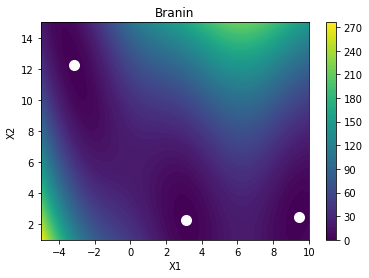

Note: in grid designs the total number of generated points is the smallest closest integer of n^d to the selected amount of points


In [6]:
#Initialise the models:

func  = GPyOpt.objective_examples.experiments2d.branin()

objective = GPyOpt.core.task.SingleObjective(func.f)
space = GPyOpt.Design_space(space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-5,10)},
                                    {'name': 'var_2', 'type': 'continuous', 'domain': (1,15)}])
model = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
initial_design = GPyOpt.experiment_design.initial_design('grid', space, 1)
acquisition = GPyOpt.acquisitions.select_acquisition('EI')(model, space, optimizer=acquisition_optimizer, jitter=0)
acquisition_lp = GPyOpt.acquisitions.select_acquisition('LP')(model, space, acquisition_optimizer, acquisition)
batch_num=5
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
evaluator_lp = GPyOpt.core.evaluators.LocalPenalization(acquisition_lp, batch_num)
max_iter=4

domain = [{'name': 'var_1', 'type': 'continuous', 'domain': bounds[0]}, ## use default bounds
          {'name': 'var_2', 'type': 'continuous', 'domain': bounds[1]}]

In [9]:
runs = 5
# Run simulations and collect output data:

kb_best_list=[]
cl_best_list = []
lp_best_list = []
ei_best_list = []

for i in range(1, runs+1):
    #Kriging Believer
    np.random.seed(i) #Use common random numbers
    
    bo_kb = ModifiedModularBO(model, space, objective, acquisition, evaluator, initial_design, method_type='KB', batch_num=batch_num)                                      
    bo_kb.run_optimization(max_iter=max_iter) 
    
    Y_best = bo_kb.Y_best
    
    if len(Y_best) < max_iter * batch_num + 1:
        Y_best = np.concatenate((Y_best, np.full((1 + max_iter * batch_num -len(Y_best)), Y_best[-1])))
    kb_best_list.append(Y_best)
    
    
    
    #Constant Liar - minimum
    np.random.seed(i)
    
    bo_clmin = ModifiedModularBO(model, space, objective, acquisition, evaluator, initial_design, method_type='CL_min', batch_num=batch_num)
    bo_clmin.run_optimization(max_iter=max_iter)
    Y_best = bo_clmin.Y_best
    
    if len(Y_best) < max_iter * batch_num + 1:
        Y_best = np.concatenate((Y_best, np.full((1 + max_iter * batch_num -len(Y_best)), Y_best[-1])))
    cl_best_list.append(Y_best)
    
    
    
    #Local Penalisation
    np.random.seed(i)
    
    bo_lp = ModularBayesianOptimization(model, space, objective, acquisition_lp, evaluator_lp, initial_design)
    bo_lp.run_optimization(max_iter=max_iter)
    Y_best = bo_lp.Y_best
    
    if len(Y_best) < max_iter * batch_num + 1:
        Y_best = np.concatenate((Y_best, np.full((1 + max_iter * batch_num -len(Y_best)), Y_best[-1])))
    lp_best_list.append(Y_best)
    
    
    
    #Sequential Expected Improvement
    np.random.seed(i)
    
    bo_ei = ModularBayesianOptimization(model, space, objective, acquisition, evaluator, initial_design)
    bo_ei.run_optimization(max_iter=max_iter*batch_num)
    
    Y_best = bo_ei.Y_best
    
    if len(Y_best) < max_iter * batch_num + 1:
        Y_best = np.concatenate((Y_best, np.full((1 + max_iter * batch_num -len(Y_best)), Y_best[-1])))
    ei_best_list.append(Y_best)
    
    
    
    print(f"Iteration {i} complete")

kb_best_avg = np.mean(np.vstack(kb_best_list), axis=0)
cl_best_avg = np.mean(np.vstack(cl_best_list), axis=0)
lp_best_avg = np.mean(np.vstack(lp_best_list), axis=0)
ei_best_avg = np.mean(np.vstack(ei_best_list), axis=0)

kb_best_std = np.std(np.vstack(kb_best_list), axis=0)
cl_best_std = np.std(np.vstack(cl_best_list), axis=0)
lp_best_std = np.std(np.vstack(lp_best_list), axis=0)
ei_best_std = np.std(np.vstack(ei_best_list), axis=0)

Iteration 1 complete
Iteration 2 complete
Iteration 3 complete
Iteration 4 complete
Iteration 5 complete


Plots of the generated output:

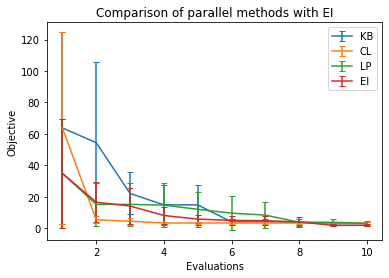

In [10]:
results_avg=pd.DataFrame({"KB":kb_best_avg,
                          "CL":cl_best_avg,
                          "LP":lp_best_avg,
                          "EI":ei_best_avg})
results_avg = deepcopy(results_avg[1:11])
results_std=pd.DataFrame({"KB":kb_best_std,
                          "CL":cl_best_std,
                          "LP":lp_best_std,
                          "EI":ei_best_std})
results_std = deepcopy(results_std[1:11])
plt.errorbar(x=range(1, 11), y=results_avg["KB"].values, yerr=results_std["KB"].values, label="KB", capsize=3)
plt.errorbar(x=range(1, 11), y=results_avg["CL"].values, yerr=results_std["CL"].values, label="CL", capsize=3)
plt.errorbar(x=range(1, 11), y=results_avg["LP"].values, yerr=results_std["LP"].values, label="LP", capsize=3)
plt.errorbar(x=range(1, 11), y=results_avg["EI"].values, yerr=results_std["EI"].values, label="EI", capsize=3)

plt.legend(loc='upper right')
plt.title("Comparison of parallel methods with EI")
plt.xlabel("Evaluations")
plt.ylabel("Objective")

plt.show()
